In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [4]:
crypto = 'BTC'
currency = 'USD'


start = dt.datetime(2016,1,1)

end = dt.datetime.now()


data = web.DataReader( f'{crypto}-{currency}' , 'yahoo' , start , end)

In [5]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,3.627890e+07,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,3.009660e+07,433.437988
2016-01-03,433.743011,424.705994,433.578003,430.010986,3.963380e+07,430.010986
2016-01-04,434.516998,429.084015,430.061005,433.091003,3.847750e+07,433.091003
2016-01-05,434.182007,429.675995,433.069000,431.959991,3.452260e+07,431.959991
...,...,...,...,...,...,...
2021-09-09,47031.742188,44344.484375,46396.664062,44883.910156,3.915467e+10,44883.910156
2021-09-10,45969.292969,44818.265625,44869.839844,45201.457031,3.449984e+10,45201.457031
2021-09-11,46364.878906,44790.460938,45206.628906,46063.269531,2.788198e+10,46063.269531


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [7]:
prediction_days = 60 #train for 60 days to predict the 61st day


x_train , y_train = [] , []

for x in range ( prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
    
    
x_train , y_train = np.array(x_train) , np.array(y_train)

x_train = np.reshape(x_train , (x_train.shape[0] , x_train.shape[1], 1))



In [8]:
#Creating Neural Networks


model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape= (x_train.shape[1] , 1)))

model.add(Dropout(0.2)) #to prevent overfitting

model.add(LSTM(units = 50 , return_sequences = True))

model.add(Dropout(0.2))

model.add(LSTM(units = 50) ) 

model.add(Dropout(0.2))
          
model.add(Dense(units = 1))

model.compile(optimizer = 'adam' , loss = 'mean_squared_error')

model.fit(x_train, y_train, epochs = 25 , batch_size = 32) 

Epoch 1/25
64/64 [==============================] - 3s 52ms/step - loss: 0.0076
Epoch 2/25
64/64 [==============================] - 3s 48ms/step - loss: 0.0023
Epoch 3/25
64/64 [==============================] - 3s 50ms/step - loss: 0.0020
Epoch 4/25
64/64 [==============================] - 4s 62ms/step - loss: 0.0021
Epoch 5/25
64/64 [==============================] - 3s 53ms/step - loss: 0.0017
Epoch 6/25
64/64 [==============================] - 3s 48ms/step - loss: 0.0017
Epoch 7/25
64/64 [==============================] - 3s 44ms/step - loss: 0.0018
Epoch 8/25
64/64 [==============================] - 3s 46ms/step - loss: 0.0015
Epoch 9/25
64/64 [==============================] - 3s 51ms/step - loss: 0.0014
Epoch 10/25
64/64 [==============================] - 3s 54ms/step - loss: 0.0014
Epoch 11/25
64/64 [==============================] - 4s 67ms/step - loss: 0.0012
Epoch 12/25
64/64 [==============================] - 4s 64ms/step - loss: 0.0013
Epoch 13/25
64/64 [==================

In [9]:
#Testing the model 


test_start = dt.datetime(2020,1,1)

test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto}-{currency}' , 'yahoo' , test_start , test_end)

actual_prices = test_data['Close'].values

In [10]:
total_dataset = pd.concat((data['Close'], test_data['Close']) , axis = 0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

In [11]:
model_inputs = model_inputs.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))

model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x , 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test , (x_test.shape[0] , x_test.shape[1], 1))

prediction_prices = model.predict(x_test)

prediction_p = scaler.inverse_transform(prediction_prices)



## Plotting the prediction and the actual prices

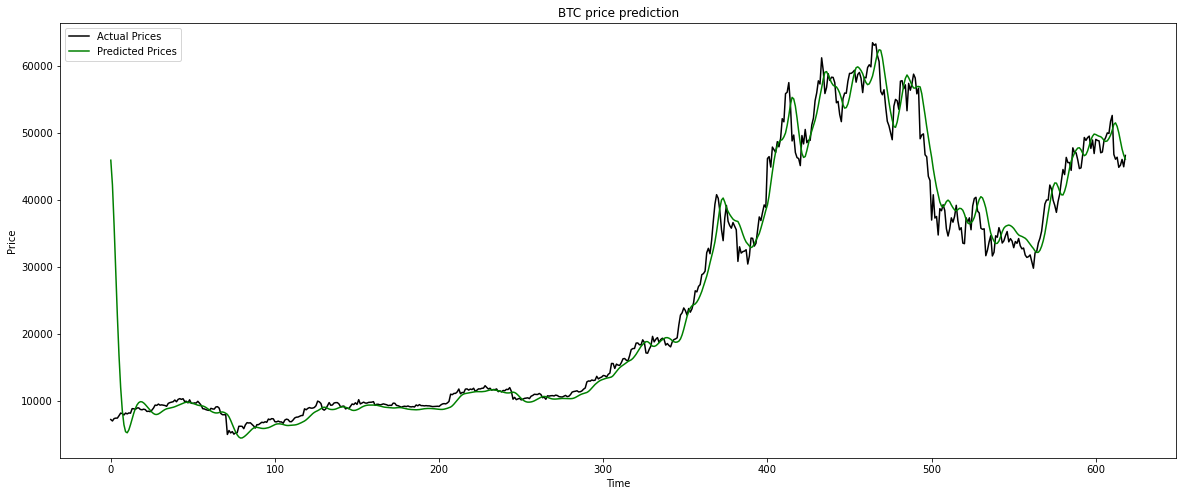

In [12]:
plt.figure(figsize=(20,8))

plt.plot(actual_prices, color = 'black' , label = 'Actual Prices' )

plt.plot(prediction_p , color = 'green' , label = 'Predicted Prices')

plt.title(f'{crypto} price prediction')

plt.xlabel('Time')

plt.ylabel('Price')

plt.legend(loc = 'upper left')

plt.show()

## Predict next day



In [13]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]

real_data = np.array(real_data)

real_data = np.reshape(real_data , (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)

pd = scaler.inverse_transform(prediction)

print("Predictions for the next day are" , pd)

Predictions for the next day are [[45947.13]]
